In [8]:
import glob
import re

import numpy as np
import pandas as pd
import tqdm
import itertools

from matplotlib import pyplot as plt
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg')
# pd.options.display.max_columns = 2000

/tmp/ipykernel_49462/852304358.py:11: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg')


In [9]:
def convert_times_2_timedelta(time_s):
    time_s = time_s.strip()
    if not time_s.endswith("s"):
        return float(time_s)
    else:
        return pd.Timedelta(time_s) / np.timedelta64(1, "us")


def remove_emptystr_in_list(l):
    return list(filter(lambda x: x.strip() != "", l))


def strip_each_in_list(l):
    return [each.strip() for each in l]


def get_worker_lat_and_tps(log_file):
    with open(log_file) as f:
        s = f.readlines()
    d = dict()
    for each_line in s:
        r = each_line.split("|")
        r = remove_emptystr_in_list(r)
        r = strip_each_in_list(r)
        if (len(r) == 3 or len(r) == 4) and r[0] != "Name":
            for i in range(1, len(r)):
                r[i] = convert_times_2_timedelta(r[i])
            d[f"[D] {r[0]}_Mean"] = r[1]
            d[f"[D] {r[0]}_P99"] = r[2]
            if len(r) == 4:
                d[f"{r[0]}_now"] = r[3]
    return d



def parse_logs_to_df(exp_dir):
    df = pd.DataFrame()
    log_files = glob.glob(f"{exp_dir}/*")
    # log_files = [f'{exp_dir}/run_{each}' for each in range(320)]
    for run_path in tqdm.tqdm(log_files):
        run_id= run_path.split("/")[-1]
        logfile = f'{run_path}/log'
        config_file= f'{run_path}/config'
        d = dict()
        d["run_id"] = run_id
        d2 = get_worker_lat_and_tps(logfile)
        d.update(d2)
        import json

        with open(config_file, "r") as f:
            config_dict = json.loads(''.join(f.readlines()[:-1]))
        d.update(config_dict)

        # df = df.append(d, ignore_index=True)

        df_dictionary = pd.DataFrame([d])
        df = pd.concat([df, df_dictionary], ignore_index=True)
        

        
    # df.drop(df[df['TPS_Mkv/s'] ==0].index, inplace=True)
    # del df['client_logtostderr']
    # del df['server_logtostderr']
    int_columns = [
        'emb_dim',
        'key_space_M',
        'query_count',
        ]

    df = df.astype({k: int for k in int_columns})

    return df

In [10]:
def TidyQueryStr(query_string):
	# query_string = query_string.replace('false', '"false"')
	# query_string = query_string.replace('true', '"true"')
	return query_string


def DecoupleAnalysis(df, for_variables, line_variables, x_variable, y_variable, sort_variable, mark_variable=None):
	if type(for_variables) is not list:
		for_variables = [for_variables]
	if type(line_variables) is not list:
		line_variables = [line_variables]

	if type(y_variable) is not list:
		y_variable = [y_variable]
	
	if type(x_variable) is not str:
		raise Exception("current only support one x variable")

	# for each graph
	for each_graph_specified in itertools.product(*[df[_].unique() for _ in for_variables]):
		kv_pair = list(zip(for_variables, each_graph_specified))
		graph_query_string = ' and '.join([f'{k}=={v}' for k,v in kv_pair])
		graph_query_string = TidyQueryStr(graph_query_string)
		# display("graph_query_string", graph_query_string)
		sub_df = df.query(graph_query_string)
		# display("graph", sub_df)
		plt.figure(figsize=(10, 5))
		plt.title(f'{kv_pair}')
		# for each line
		for each_line_specified in itertools.product(*[sub_df[_].unique() for _ in line_variables]):
			line_specified_kv_pair = list(zip(line_variables, each_line_specified))
			# convert string to "string" for query
			for each in range(len(line_specified_kv_pair)):
				if type(line_specified_kv_pair[each][1]) == str:
					line_specified_kv_pair[each] =  (line_specified_kv_pair[each][0], f'"{line_specified_kv_pair[each][1]}"')

			line_query_string = ' and '.join([f'{k}=={v}' for k,v in line_specified_kv_pair])
			line_query_string = TidyQueryStr(line_query_string)
			subsub_df = sub_df.query(line_query_string)
			
			# display(subsub_df)
			
			# 避免画两组数据在一根线上
			if len(subsub_df[sort_variable].unique()) != len(subsub_df):
				display(subsub_df)
				subsub_df.to_csv("fordebug.csv")
				raise Exception(f"len(subsub_df[sort_variable].unique()) != len(subsub_df)"
				f"({len(subsub_df[sort_variable].unique())} vs {len(subsub_df)})"
				)

			for each_y_variable in y_variable:
				if mark_variable is None:
					other_variables = (subsub_df['run_id'],)
				else:
					other_variables = (subsub_df['run_id'], subsub_df[mark_variable])
				xy_pairs = sorted(zip(subsub_df[x_variable], subsub_df[each_y_variable], *other_variables, subsub_df[sort_variable]), key = lambda x:x[-1])
				x = [each[0] for each in xy_pairs]
				y = [each[1] for each in xy_pairs]
				z = [each[2:-1] for each in xy_pairs]
				plt.plot(x, y, label=f"{line_specified_kv_pair}_{each_y_variable}")

				for each_x, each_y, each_z in zip(x, y, z):
					plt.annotate(f'{each_z}', (each_x, each_y), )

		plt.xlabel(x_variable)
		plt.ylabel(str(y_variable))
		plt.legend()
		plt.show()

		# break

In [11]:
df = parse_logs_to_df('log/')
# df = parse_logs_to_df('back-log/')

100%|██████████| 10/10 [00:00<00:00, 181.06it/s]


In [12]:
df

,run_id,[D] key d2h_Mean,[D] key d2h_P99,[D] cpu gather_Mean,[D] cpu gather_P99,[D] value h2d_Mean,[D] value h2d_P99,[D] query_Mean,[D] query_P99,method,emb_dim,key_space_M,query_count,run_time,dummy
0,run_0,8.594,9.470,11.731,15.956,13.362,16.980,36.864,50.176,CPU,32,100,128,30,0
1,run_1,8.578,9.109,42.888,48.397,14.412,14.782,68.096,74.784,CPU,32,100,512,30,0
2,run_2,9.290,9.691,84.628,92.579,20.212,20.702,116.960,125.024,CPU,32,100,1024,30,0
3,run_3,8.650,9.769,123.940,133.398,25.217,25.732,160.800,170.880,CPU,32,100,1536,30,0
4,run_4,9.399,10.271,171.457,197.334,31.063,32.284,215.264,241.728,CPU,32,100,2048,30,0
5,run_5,NaN,NaN,NaN,NaN,NaN,NaN,11.264,12.288,UVA,32,100,128,30,0
6,run_6,NaN,NaN,NaN,NaN,NaN,NaN,21.504,22.528,UVA,32,100,512,30,0
7,run_7,NaN,NaN,NaN,NaN,NaN,NaN,34.816,35.840,UVA,32,100,1024,30,0
8,run_8,NaN,NaN,NaN,NaN,NaN,NaN,49.152,51.200,UVA,32,100,1536,30,0
9,run_9,NaN,NaN,NaN,NaN,NaN,NaN,62.464,63.488,UVA,32,100,2048,30,0


,run_id,[D] key d2h_Mean,[D] key d2h_P99,[D] cpu gather_Mean,[D] cpu gather_P99,[D] value h2d_Mean,[D] value h2d_P99,[D] query_Mean,[D] query_P99,method,emb_dim,key_space_M,query_count,run_time,dummy,gpu_meta_Mean
0,run_0,8.594,9.470,11.731,15.956,13.362,16.980,36.864,50.176,CPU,32,100,128,30,0,21.956
1,run_1,8.578,9.109,42.888,48.397,14.412,14.782,68.096,74.784,CPU,32,100,512,30,0,22.990
2,run_2,9.290,9.691,84.628,92.579,20.212,20.702,116.960,125.024,CPU,32,100,1024,30,0,29.502
3,run_3,8.650,9.769,123.940,133.398,25.217,25.732,160.800,170.880,CPU,32,100,1536,30,0,33.867
4,run_4,9.399,10.271,171.457,197.334,31.063,32.284,215.264,241.728,CPU,32,100,2048,30,0,40.462
5,run_5,NaN,NaN,NaN,NaN,NaN,NaN,11.264,12.288,UVA,32,100,128,30,0,0.000
6,run_6,NaN,NaN,NaN,NaN,NaN,NaN,21.504,22.528,UVA,32,100,512,30,0,0.000
7,run_7,NaN,NaN,NaN,NaN,NaN,NaN,34.816,35.840,UVA,32,100,1024,30,0,0.000
8,run_8,NaN,NaN,NaN,NaN,NaN,NaN,49.152,51.200,UVA,32,100,1536,30,0,0.000
9,run_9,NaN,NaN,NaN,NaN,NaN,NaN,62.464,63.488,UVA,32,100,2048,30,0,0.000


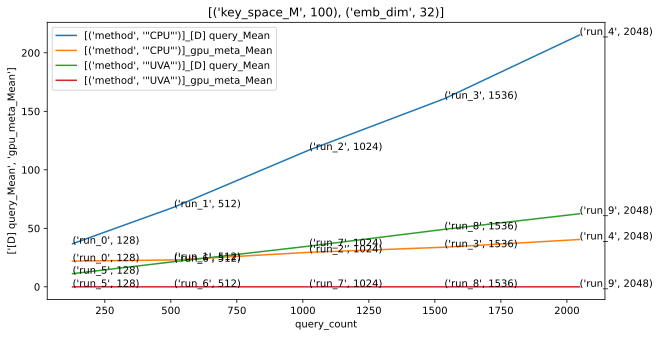

In [13]:
df['gpu_meta_Mean'] = df['[D] key d2h_Mean'].fillna(0) + df['[D] value h2d_Mean'].fillna(0)  


display(df)

df.to_csv("temp.csv", index=False)

DecoupleAnalysis(df, 
for_variables = ['key_space_M', 'emb_dim'], 
line_variables = 'method', 
x_variable = 'query_count', 
y_variable = ['[D] query_Mean', 'gpu_meta_Mean' ],
sort_variable = 'query_count',
mark_variable= 'query_count',
)

In [15]:
df

,run_id,[D] key d2h_Mean,[D] key d2h_P99,[D] cpu gather_Mean,[D] cpu gather_P99,[D] value h2d_Mean,[D] value h2d_P99,[D] query_Mean,[D] query_P99,method,emb_dim,key_space_M,query_count,run_time,dummy,gpu_meta_Mean
0,run_0,8.594,9.470,11.731,15.956,13.362,16.980,36.864,50.176,CPU,32,100,128,30,0,21.956
1,run_1,8.578,9.109,42.888,48.397,14.412,14.782,68.096,74.784,CPU,32,100,512,30,0,22.990
2,run_2,9.290,9.691,84.628,92.579,20.212,20.702,116.960,125.024,CPU,32,100,1024,30,0,29.502
3,run_3,8.650,9.769,123.940,133.398,25.217,25.732,160.800,170.880,CPU,32,100,1536,30,0,33.867
4,run_4,9.399,10.271,171.457,197.334,31.063,32.284,215.264,241.728,CPU,32,100,2048,30,0,40.462
5,run_5,NaN,NaN,NaN,NaN,NaN,NaN,11.264,12.288,UVA,32,100,128,30,0,0.000
6,run_6,NaN,NaN,NaN,NaN,NaN,NaN,21.504,22.528,UVA,32,100,512,30,0,0.000
7,run_7,NaN,NaN,NaN,NaN,NaN,NaN,34.816,35.840,UVA,32,100,1024,30,0,0.000
8,run_8,NaN,NaN,NaN,NaN,NaN,NaN,49.152,51.200,UVA,32,100,1536,30,0,0.000
9,run_9,NaN,NaN,NaN,NaN,NaN,NaN,62.464,63.488,UVA,32,100,2048,30,0,0.000


In [18]:

df = df[['key_space_M', 'emb_dim', 'query_count', 'method', '[D] query_Mean','gpu_meta_Mean']]
temp_df = df.groupby(by=['key_space_M', 'emb_dim', 'query_count', 'method']).mean()[['[D] query_Mean','gpu_meta_Mean']]
temp_df.query("key_space_M == 100").to_csv("goruped.csv")

In [19]:
temp_df.reset_index()

,key_space_M,emb_dim,query_count,method,[D] query_Mean,gpu_meta_Mean
0,100,32,128,CPU,36.864,21.956
1,100,32,128,UVA,11.264,0.000
2,100,32,512,CPU,68.096,22.990
3,100,32,512,UVA,21.504,0.000
4,100,32,1024,CPU,116.960,29.502
5,100,32,1024,UVA,34.816,0.000
6,100,32,1536,CPU,160.800,33.867
7,100,32,1536,UVA,49.152,0.000
8,100,32,2048,CPU,215.264,40.462
9,100,32,2048,UVA,62.464,0.000


In [20]:
out_df = temp_df.reset_index().pivot(index='query_count', columns='method', values='[D] query_Mean')
out_df

method,CPU,UVA
query_count,,
128,36.864,11.264
512,68.096,21.504
1024,116.960,34.816
1536,160.800,49.152
2048,215.264,62.464


In [21]:
out_df['倍数'] = out_df['CPU'] / out_df['UVA']

In [22]:
out_df

method,CPU,UVA,倍数
query_count,,,
128,36.864,11.264,3.272727
512,68.096,21.504,3.166667
1024,116.960,34.816,3.359375
1536,160.800,49.152,3.271484
2048,215.264,62.464,3.446209


In [23]:
out_df = temp_df.reset_index().pivot(index='query_count', columns='method', values=['[D] query_Mean', 'gpu_meta_Mean'])

In [24]:
out_df

[D] query_Mean         gpu_meta_Mean     
method                 CPU     UVA           CPU  UVA
query_count                                          
128                 36.864  11.264        21.956  0.0
512                 68.096  21.504        22.990  0.0
1024               116.960  34.816        29.502  0.0
1536               160.800  49.152        33.867  0.0
2048               215.264  62.464        40.462  0.0

In [ ]:
out_df.